# Multi-Label Classification dengan IndoBERT

Notebook ini melanjutkan dari preprocessing yang sudah dilakukan untuk melakukan klasifikasi multi-label menggunakan IndoBERT.

## Tahapan:
1. Preprocessing data (dari script sebelumnya)
2. Multi-label encoding
3. Fine-tuning IndoBERT
4. Evaluasi dengan micro & macro F1 score dan Hamming Loss

## 1. Preprocessing Pipeline — Stopwords NLTK (Indonesian + English)

In [40]:
# === Parameters ===
SRC_PATH = "Dataset_Ready_Codings.xlsx"
COL_TEXT = "Original Text"
EXCEL_OUT = "preprocessed_dataset_nltkstop.xlsx"
CSV_OUT   = "preprocessed_dataset_nltkstop.csv"

In [41]:
# === Install dependencies for preprocessing ===
# !pip install -q nltk pandas scikit-learn numpy openpyxl

import nltk
nltk.download('stopwords', quiet=True)

True

In [42]:
# === Imports for preprocessing ===
import pandas as pd
import re
from collections import Counter
import numpy as np
import math
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
import warnings
warnings.filterwarnings('ignore')

print("Libraries loaded.")

Libraries loaded.


In [43]:
# === Load dataset ===
df = pd.read_excel(SRC_PATH)
assert COL_TEXT in df.columns, f"Kolom '{COL_TEXT}' tidak ditemukan. Kolom tersedia: {list(df.columns)}"
print(f"Loaded shape = {df.shape}, using column = '{COL_TEXT}'")
df = df.dropna(subset=[COL_TEXT]).copy()
print(f"After dropna on '{COL_TEXT}': {df.shape}")
df.head(2)

Loaded shape = (440, 4), using column = 'Original Text'
After dropna on 'Original Text': (440, 4)


,Nama Pemimpin,Original Text,Traits,New Summary Extractive
0,Retno Marsudi,KOMPAS.com - Menteri Luar Negeri (Menlu) Retno...,"Hubungan International, Manajemen Krisis",KOMPAS.com - Menteri Luar Negeri (Menlu) Retno...
1,Retno Marsudi,"JAKARTA, KOMPAS.com - Menteri Luar Negeri Retn...","Visi & Tujuan, Kebijakan & Keputusan, Manajeme...","JAKARTA, KOMPAS.com - Menteri Luar Negeri Retn..."


In [44]:
# === Cleaning + Stopwords (NLTK) ===
url_pattern = re.compile(r"http\S+|www\.\S+")
html_pattern = re.compile(r"<.*?>")
mention_hash_pattern = re.compile(r"[@#]\w+")
non_alpha_pattern = re.compile(r"[^a-zA-Z0-9\sáàâäãåāéèêëēíìîïīóòôöõōúùûüūçñ'']")

def clean_text_basic(s: str) -> str:
    s = str(s)
    s = url_pattern.sub(" ", s)
    s = html_pattern.sub(" ", s)
    s = mention_hash_pattern.sub(" ", s)
    s = s.lower()
    s = s.replace("'", "'")
    s = non_alpha_pattern.sub(" ", s)
    s = re.sub(r"\s+", " ", s).strip()
    return s

def tokenize(s: str):
    return [t for t in s.split() if t]

# NLTK stopwords
stopwords_id = set(stopwords.words('indonesian'))
stopwords_en = set(stopwords.words('english'))
stopwords_union = stopwords_id | stopwords_en
print(f"Stopwords — ID: {len(stopwords_id)}, EN: {len(stopwords_en)}, UNION: {len(stopwords_union)}")

def remove_stopwords(toks: list) -> list:
    return [t for t in toks if t.lower() not in stopwords_union]

Stopwords — ID: 757, EN: 198, UNION: 955


In [45]:
# === Extractive Summarization ===
def summarize_extractive(text: str, ratio: float = 0.2, max_sentences: int = 6) -> str:
    """TF-IDF sentence scoring with position boost"""
    text = str(text).strip()
    if not text:
        return ""
    
    # Split sentences
    sentences = re.split(r'(?<=[.!?])\s+', text)
    sentences = [s.strip() for s in sentences if s.strip()]
    
    if len(sentences) <= 1:
        return text
    
    # Clean sentences for TF-IDF
    clean_sents = [clean_text_basic(s) for s in sentences]
    
    # TF-IDF scoring
    try:
        vectorizer = TfidfVectorizer()
        tfidf_matrix = vectorizer.fit_transform(clean_sents)
        scores = tfidf_matrix.sum(axis=1).A1
    except:
        scores = np.ones(len(sentences))
    
    # Position boost
    position_boost = np.array([1.2 if i < 2 else 1.0 for i in range(len(sentences))])
    final_scores = scores * position_boost
    
    # Select top sentences
    n_select = max(1, min(int(len(sentences) * ratio), max_sentences))
    top_indices = np.argsort(final_scores)[-n_select:]
    top_indices = sorted(top_indices)  # maintain order
    
    selected = [sentences[i] for i in top_indices]
    return " ".join(selected)

In [46]:
# === Run preprocessing ===
df["cleaned_text"]   = df[COL_TEXT].astype(str).map(clean_text_basic)
df["tokens"]         = df["cleaned_text"].map(tokenize)
df["tokens_nostop"]  = df["tokens"].map(remove_stopwords)
df["label"] = df["Traits"]
df["summary_20pct"]  = df[COL_TEXT].astype(str).map(lambda x: summarize_extractive(x, ratio=0.2, max_sentences=6))

cols_out = [COL_TEXT, "cleaned_text", "tokens", "tokens_nostop", "summary_20pct", "label"]
out_df = df[cols_out].copy()

# Save preprocessed data
out_df.to_excel(EXCEL_OUT, index=False)
out_df.to_csv(CSV_OUT, index=False, encoding="utf-8")
print(f"Preprocessed data shape: {out_df.shape}")
out_df.head()

Preprocessed data shape: (440, 6)


,Original Text,cleaned_text,tokens,tokens_nostop,summary_20pct,label
0,KOMPAS.com - Menteri Luar Negeri (Menlu) Retno...,kompas com menteri luar negeri menlu retno mar...,"[kompas, com, menteri, luar, negeri, menlu, re...","[kompas, com, menteri, negeri, menlu, retno, m...",KOMPAS.com - Menteri Luar Negeri (Menlu) Retno...,"Hubungan International, Manajemen Krisis"
1,"JAKARTA, KOMPAS.com - Menteri Luar Negeri Retn...",jakarta kompas com menteri luar negeri retno m...,"[jakarta, kompas, com, menteri, luar, negeri, ...","[jakarta, kompas, com, menteri, negeri, retno,...",Hal itu Retno katakan di hadapan negara-negara...,"Visi & Tujuan, Kebijakan & Keputusan, Manajeme..."
2,"JAKARTA, KOMPAS.com - Menteri Luar Negeri (Men...",jakarta kompas com menteri luar negeri menlu r...,"[jakarta, kompas, com, menteri, luar, negeri, ...","[jakarta, kompas, com, menteri, negeri, menlu,...",Hal itu disampaikannya saat berbicara di forum...,"Kebijakan & Keputusan, Manajemen Krisis, Kemaj..."
3,"JAKARTA, KOMPAS.com - Menteri Luar Negeri Retn...",jakarta kompas com menteri luar negeri retno m...,"[jakarta, kompas, com, menteri, luar, negeri, ...","[jakarta, kompas, com, menteri, negeri, retno,...","JAKARTA, KOMPAS.com - Menteri Luar Negeri Retn...","Manajemen Krisis, Kemajuan & Prestasi, Keterli..."
4,"JAKARTA, KOMPAS.com - Menteri Keuangan (Menkeu...",jakarta kompas com menteri keuangan menkeu sri...,"[jakarta, kompas, com, menteri, keuangan, menk...","[jakarta, kompas, com, menteri, keuangan, menk...","JAKARTA, KOMPAS.com - Menteri Keuangan (Menkeu...",Nilai & Prinsip


## 2. Multi-Label Classification dengan IndoBERT

In [47]:
# === Install dependencies untuk IndoBERT ===
# !pip install -q transformers torch torchvision torchaudio
# !pip install -q scikit-learn
# !pip install -q tqdm

# print("Dependencies installed successfully!")

In [48]:
# === Imports untuk IndoBERT ===
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModel, get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import f1_score, hamming_loss, classification_report
from tqdm import tqdm
import json
from typing import List, Dict, Tuple

# Check if CUDA is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Set seed for reproducibility
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

Using device: cuda


In [49]:
# === Load preprocessed data ===
data_df = pd.read_csv(CSV_OUT)
print(f"Loaded data shape: {data_df.shape}")

# Process labels (multi-label)
def process_labels(label_str):
    """Convert label string to list of labels"""
    if pd.isna(label_str):
        return []
    # Split by comma and strip whitespace
    labels = [l.strip() for l in str(label_str).split(',')]
    return labels

data_df['labels_list'] = data_df['label'].apply(process_labels)

# Get all unique labels
all_labels = set()
for labels in data_df['labels_list']:
    all_labels.update(labels)
all_labels = sorted(list(all_labels))
print(f"Total unique labels: {len(all_labels)}")
print(f"Labels: {all_labels}")

Loaded data shape: (440, 6)
Total unique labels: 8
Labels: ['Hubungan International', 'Kebijakan & Keputusan', 'Kemajuan & Prestasi', 'Keterlibatan Publik', 'Manajemen Krisis', 'Nilai & Prinsip', 'Tantangan & Hambatan', 'Visi & Tujuan']


In [50]:
# === Prepare data for multi-label classification ===
# Use summary text for classification
texts = data_df['summary_20pct'].tolist()
labels = data_df['labels_list'].tolist()

# Multi-label binarization
mlb = MultiLabelBinarizer()
y = mlb.fit_transform(labels)
print(f"Label matrix shape: {y.shape}")
print(f"Classes: {mlb.classes_}")

# Split data
X_train, X_temp, y_train, y_temp = train_test_split(
    texts, y, test_size=0.3, random_state=SEED, stratify=None
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=SEED, stratify=None
)

print(f"Train size: {len(X_train)}")
print(f"Val size: {len(X_val)}")
print(f"Test size: {len(X_test)}")

Label matrix shape: (440, 8)
Classes: ['Hubungan International' 'Kebijakan & Keputusan' 'Kemajuan & Prestasi'
 'Keterlibatan Publik' 'Manajemen Krisis' 'Nilai & Prinsip'
 'Tantangan & Hambatan' 'Visi & Tujuan']
Train size: 308
Val size: 66
Test size: 66


In [51]:
# === Dataset class for IndoBERT ===
class MultiLabelDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=256):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]
        
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )
        
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.FloatTensor(label)
        }

In [52]:
# === IndoBERT Multi-label Classifier ===
class IndoBERTMultiLabelClassifier(nn.Module):
    def __init__(self, model_name, num_labels, dropout=0.3):
        super(IndoBERTMultiLabelClassifier, self).__init__()
        self.bert = AutoModel.from_pretrained(model_name)
        self.dropout = nn.Dropout(dropout)
        self.classifier = nn.Linear(self.bert.config.hidden_size, num_labels)
        
    def forward(self, input_ids, attention_mask):
        outputs = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        pooled_output = outputs.pooler_output
        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)
        return logits

In [53]:
# === Initialize IndoBERT model and tokenizer ===
MODEL_NAME = "indobenchmark/indobert-base-p1"
MAX_LENGTH = 256
BATCH_SIZE = 16
LEARNING_RATE = 1e-5
EPOCHS = 16

print(f"Loading IndoBERT: {MODEL_NAME}")
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = IndoBERTMultiLabelClassifier(MODEL_NAME, len(mlb.classes_))
model = model.to(device)

print(f"Model loaded successfully!")
print(f"Number of parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")

Loading IndoBERT: indobenchmark/indobert-base-p1
Model loaded successfully!
Number of parameters: 124,447,496


In [54]:
# === Create DataLoaders ===
train_dataset = MultiLabelDataset(X_train, y_train, tokenizer, MAX_LENGTH)
val_dataset = MultiLabelDataset(X_val, y_val, tokenizer, MAX_LENGTH)
test_dataset = MultiLabelDataset(X_test, y_test, tokenizer, MAX_LENGTH)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"DataLoaders created successfully!")

DataLoaders created successfully!


In [55]:
# === Training and Evaluation Functions ===
def train_epoch(model, dataloader, optimizer, scheduler, criterion, device):
    model.train()
    total_loss = 0
    
    progress_bar = tqdm(dataloader, desc="Training")
    for batch in progress_bar:
        optimizer.zero_grad()
        
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        
        outputs = model(input_ids, attention_mask)
        loss = criterion(outputs, labels)
        
        loss.backward()
        optimizer.step()
        scheduler.step()
        
        total_loss += loss.item()
        progress_bar.set_postfix({'loss': loss.item()})
    
    return total_loss / len(dataloader)

def evaluate(model, dataloader, criterion, device, threshold=0.5):
    model.eval()
    total_loss = 0
    all_predictions = []
    all_labels = []
    
    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            
            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            
            # Apply sigmoid and threshold
            predictions = torch.sigmoid(outputs) > threshold
            
            all_predictions.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    all_predictions = np.array(all_predictions)
    all_labels = np.array(all_labels)
    
    # Calculate metrics
    micro_f1 = f1_score(all_labels, all_predictions, average='micro')
    macro_f1 = f1_score(all_labels, all_predictions, average='macro')
    hamming = hamming_loss(all_labels, all_predictions)
    
    return {
        'loss': total_loss / len(dataloader),
        'micro_f1': micro_f1,
        'macro_f1': macro_f1,
        'hamming_loss': hamming,
        'predictions': all_predictions,
        'labels': all_labels
    }

In [56]:
# === Setup training ===
# Loss function for multi-label classification
criterion = nn.BCEWithLogitsLoss()

# Optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE)

# Scheduler
total_steps = len(train_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=total_steps // 10,
    num_training_steps=total_steps
)

print("Training setup complete!")

Training setup complete!


In [57]:
# === Training Loop ===
best_val_f1 = 0
training_history = {
    'train_loss': [],
    'val_loss': [],
    'val_micro_f1': [],
    'val_macro_f1': [],
    'val_hamming_loss': []
}

print("Starting training...")
for epoch in range(EPOCHS):
    print(f"\n{'='*50}")
    print(f"Epoch {epoch+1}/{EPOCHS}")
    print(f"{'='*50}")
    
    # Train
    train_loss = train_epoch(model, train_loader, optimizer, scheduler, criterion, device)
    print(f"Train Loss: {train_loss:.4f}")
    
    # Validate
    val_results = evaluate(model, val_loader, criterion, device)
    print(f"Validation Loss: {val_results['loss']:.4f}")
    print(f"Validation Micro F1: {val_results['micro_f1']:.4f}")
    print(f"Validation Macro F1: {val_results['macro_f1']:.4f}")
    print(f"Validation Hamming Loss: {val_results['hamming_loss']:.4f}")
    
    # Save history
    training_history['train_loss'].append(train_loss)
    training_history['val_loss'].append(val_results['loss'])
    training_history['val_micro_f1'].append(val_results['micro_f1'])
    training_history['val_macro_f1'].append(val_results['macro_f1'])
    training_history['val_hamming_loss'].append(val_results['hamming_loss'])
    
    # Save best model
    if val_results['micro_f1'] > best_val_f1:
        best_val_f1 = val_results['micro_f1']
        torch.save(model.state_dict(), 'best_model.pt')
        print(f"✓ New best model saved! (Micro F1: {best_val_f1:.4f})")

print("\nTraining completed!")

Starting training...

Epoch 1/16


Training: 100%|██████████| 20/20 [00:08<00:00,  2.31it/s, loss=0.543]


Train Loss: 0.6649


Evaluating: 100%|██████████| 5/5 [00:00<00:00,  8.46it/s]


Validation Loss: 0.5704
Validation Micro F1: 0.1566
Validation Macro F1: 0.0492
Validation Hamming Loss: 0.2652
✓ New best model saved! (Micro F1: 0.1566)

Epoch 2/16


Training: 100%|██████████| 20/20 [00:08<00:00,  2.49it/s, loss=0.646]


Train Loss: 0.5527


Evaluating: 100%|██████████| 5/5 [00:00<00:00,  9.07it/s]


Validation Loss: 0.5153
Validation Micro F1: 0.0000
Validation Macro F1: 0.0000
Validation Hamming Loss: 0.2292

Epoch 3/16


Training: 100%|██████████| 20/20 [00:08<00:00,  2.41it/s, loss=0.467]


Train Loss: 0.5257


Evaluating: 100%|██████████| 5/5 [00:00<00:00,  8.49it/s]


Validation Loss: 0.5052
Validation Micro F1: 0.0164
Validation Macro F1: 0.0081
Validation Hamming Loss: 0.2273

Epoch 4/16


Training: 100%|██████████| 20/20 [00:08<00:00,  2.31it/s, loss=0.614]


Train Loss: 0.5263


Evaluating: 100%|██████████| 5/5 [00:00<00:00,  8.46it/s]


Validation Loss: 0.5050
Validation Micro F1: 0.1185
Validation Macro F1: 0.0611
Validation Hamming Loss: 0.2254

Epoch 5/16


Training: 100%|██████████| 20/20 [00:08<00:00,  2.30it/s, loss=0.532]


Train Loss: 0.5106


Evaluating: 100%|██████████| 5/5 [00:00<00:00,  8.21it/s]


Validation Loss: 0.5013
Validation Micro F1: 0.1077
Validation Macro F1: 0.0449
Validation Hamming Loss: 0.2197

Epoch 6/16


Training: 100%|██████████| 20/20 [00:08<00:00,  2.44it/s, loss=0.547]


Train Loss: 0.4934


Evaluating: 100%|██████████| 5/5 [00:00<00:00,  8.96it/s]


Validation Loss: 0.4960
Validation Micro F1: 0.2649
Validation Macro F1: 0.1206
Validation Hamming Loss: 0.2102
✓ New best model saved! (Micro F1: 0.2649)

Epoch 7/16


Training: 100%|██████████| 20/20 [00:08<00:00,  2.47it/s, loss=0.535]


Train Loss: 0.4795


Evaluating: 100%|██████████| 5/5 [00:00<00:00,  8.85it/s]


Validation Loss: 0.4908
Validation Micro F1: 0.3046
Validation Macro F1: 0.1368
Validation Hamming Loss: 0.1989
✓ New best model saved! (Micro F1: 0.3046)

Epoch 8/16


Training: 100%|██████████| 20/20 [00:08<00:00,  2.44it/s, loss=0.54] 


Train Loss: 0.4615


Evaluating: 100%|██████████| 5/5 [00:00<00:00,  8.57it/s]


Validation Loss: 0.4837
Validation Micro F1: 0.3780
Validation Macro F1: 0.1610
Validation Hamming Loss: 0.1932
✓ New best model saved! (Micro F1: 0.3780)

Epoch 9/16


Training: 100%|██████████| 20/20 [00:08<00:00,  2.31it/s, loss=0.335]


Train Loss: 0.4395


Evaluating: 100%|██████████| 5/5 [00:00<00:00,  8.25it/s]


Validation Loss: 0.4868
Validation Micro F1: 0.3757
Validation Macro F1: 0.1820
Validation Hamming Loss: 0.2140

Epoch 10/16


Training: 100%|██████████| 20/20 [00:08<00:00,  2.29it/s, loss=0.424]


Train Loss: 0.4238


Evaluating: 100%|██████████| 5/5 [00:00<00:00,  8.63it/s]


Validation Loss: 0.4792
Validation Micro F1: 0.3952
Validation Macro F1: 0.2211
Validation Hamming Loss: 0.1913
✓ New best model saved! (Micro F1: 0.3952)

Epoch 11/16


Training: 100%|██████████| 20/20 [00:08<00:00,  2.44it/s, loss=0.33] 


Train Loss: 0.4017


Evaluating: 100%|██████████| 5/5 [00:00<00:00,  8.77it/s]


Validation Loss: 0.4788
Validation Micro F1: 0.4162
Validation Macro F1: 0.2230
Validation Hamming Loss: 0.1913
✓ New best model saved! (Micro F1: 0.4162)

Epoch 12/16


Training: 100%|██████████| 20/20 [00:08<00:00,  2.42it/s, loss=0.365]


Train Loss: 0.3847


Evaluating: 100%|██████████| 5/5 [00:00<00:00,  8.42it/s]


Validation Loss: 0.4841
Validation Micro F1: 0.4420
Validation Macro F1: 0.2569
Validation Hamming Loss: 0.1913
✓ New best model saved! (Micro F1: 0.4420)

Epoch 13/16


Training: 100%|██████████| 20/20 [00:08<00:00,  2.43it/s, loss=0.355]


Train Loss: 0.3769


Evaluating: 100%|██████████| 5/5 [00:00<00:00,  8.72it/s]


Validation Loss: 0.4802
Validation Micro F1: 0.4222
Validation Macro F1: 0.2301
Validation Hamming Loss: 0.1970

Epoch 14/16


Training: 100%|██████████| 20/20 [00:08<00:00,  2.44it/s, loss=0.453]


Train Loss: 0.3719


Evaluating: 100%|██████████| 5/5 [00:00<00:00,  8.78it/s]


Validation Loss: 0.4839
Validation Micro F1: 0.4590
Validation Macro F1: 0.2802
Validation Hamming Loss: 0.1875
✓ New best model saved! (Micro F1: 0.4590)

Epoch 15/16


Training: 100%|██████████| 20/20 [00:08<00:00,  2.44it/s, loss=0.427]


Train Loss: 0.3623


Evaluating: 100%|██████████| 5/5 [00:00<00:00,  8.70it/s]


Validation Loss: 0.4837
Validation Micro F1: 0.4396
Validation Macro F1: 0.2588
Validation Hamming Loss: 0.1932

Epoch 16/16


Training: 100%|██████████| 20/20 [00:08<00:00,  2.44it/s, loss=0.326]


Train Loss: 0.3539


Evaluating: 100%|██████████| 5/5 [00:00<00:00,  8.83it/s]

Validation Loss: 0.4838
Validation Micro F1: 0.4457
Validation Macro F1: 0.2649
Validation Hamming Loss: 0.1932

Training completed!


In [58]:
# === Test Set Evaluation ===
print("\n" + "="*60)
print("FINAL TEST SET EVALUATION")
print("="*60)

# Load best model
model.load_state_dict(torch.load('best_model.pt'))
print("Best model loaded!\n")

# Evaluate on test set
test_results = evaluate(model, test_loader, criterion, device)

print("\n🎯 TEST SET RESULTS:")
print(f"  • Test Loss: {test_results['loss']:.4f}")
print(f"  • Micro F1 Score: {test_results['micro_f1']:.4f}")
print(f"  • Macro F1 Score: {test_results['macro_f1']:.4f}")
print(f"  • Hamming Loss: {test_results['hamming_loss']:.4f}")


FINAL TEST SET EVALUATION
Best model loaded!



Evaluating: 100%|██████████| 5/5 [00:00<00:00,  8.87it/s]


🎯 TEST SET RESULTS:
  • Test Loss: 0.5151
  • Micro F1 Score: 0.3400
  • Macro F1 Score: 0.2169
  • Hamming Loss: 0.2500


In [59]:
# === Per-label Performance Analysis ===
from sklearn.metrics import precision_recall_fscore_support

print("\n" + "="*60)
print("PER-LABEL PERFORMANCE ANALYSIS")
print("="*60)

# Calculate per-label metrics
precision, recall, f1, support = precision_recall_fscore_support(
    test_results['labels'], 
    test_results['predictions'],
    average=None
)

# Create performance DataFrame
label_performance = pd.DataFrame({
    'Label': mlb.classes_,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1,
    'Support': support.astype(int),
    'Hamming Loss': [hamming_loss(test_results['labels'][:, i], test_results['predictions'][:, i]) 
                     for i in range(len(mlb.classes_))]
})

# Sort by F1-score
label_performance = label_performance.sort_values('F1-Score', ascending=False)

# Display results
print("\n📊 Detailed Metrics per Label:\n")
print(label_performance.to_string(index=False, float_format='%.3f'))

# Calculate and display average metrics
print("\n📈 Summary Statistics:")
print(f"  • Average Precision: {label_performance['Precision'].mean():.3f}")
print(f"  • Average Recall: {label_performance['Recall'].mean():.3f}")
print(f"  • Average F1-Score: {label_performance['F1-Score'].mean():.3f}")
print(f"  • Average Hamming Loss per Label: {label_performance['Hamming Loss'].mean():.3f}")


PER-LABEL PERFORMANCE ANALYSIS

📊 Detailed Metrics per Label:

                 Label  Precision  Recall  F1-Score  Support  Hamming Loss
       Nilai & Prinsip      0.875   0.519     0.651       27         0.227
   Keterlibatan Publik      0.519   0.500     0.509       28         0.409
         Visi & Tujuan      0.667   0.125     0.211       16         0.227
 Kebijakan & Keputusan      0.250   0.105     0.148       19         0.348
      Manajemen Krisis      0.500   0.071     0.125       14         0.212
   Kemajuan & Prestasi      0.333   0.053     0.091       19         0.303
Hubungan International      0.000   0.000     0.000        4         0.061
  Tantangan & Hambatan      0.000   0.000     0.000       14         0.212

📈 Summary Statistics:
  • Average Precision: 0.393
  • Average Recall: 0.172
  • Average F1-Score: 0.217
  • Average Hamming Loss per Label: 0.250


In [60]:
# === Save Results ===
# Save performance metrics to Excel
label_performance.to_excel('label_performance_metrics.xlsx', index=False)
print("\n✅ Label performance metrics saved to 'label_performance_metrics.xlsx'")

# Save overall results to JSON
overall_results = {
    'model': MODEL_NAME,
    'test_metrics': {
        'loss': float(test_results['loss']),
        'micro_f1': float(test_results['micro_f1']),
        'macro_f1': float(test_results['macro_f1']),
        'hamming_loss': float(test_results['hamming_loss'])
    },
    'training_config': {
        'batch_size': BATCH_SIZE,
        'learning_rate': LEARNING_RATE,
        'epochs': EPOCHS,
        'max_length': MAX_LENGTH
    },
    'dataset_info': {
        'total_samples': len(data_df),
        'train_size': len(X_train),
        'val_size': len(X_val),
        'test_size': len(X_test),
        'num_labels': len(mlb.classes_)
    }
}

with open('training_results.json', 'w') as f:
    json.dump(overall_results, f, indent=2)

print("✅ Overall results saved to 'training_results.json'")


✅ Label performance metrics saved to 'label_performance_metrics.xlsx'
✅ Overall results saved to 'training_results.json'


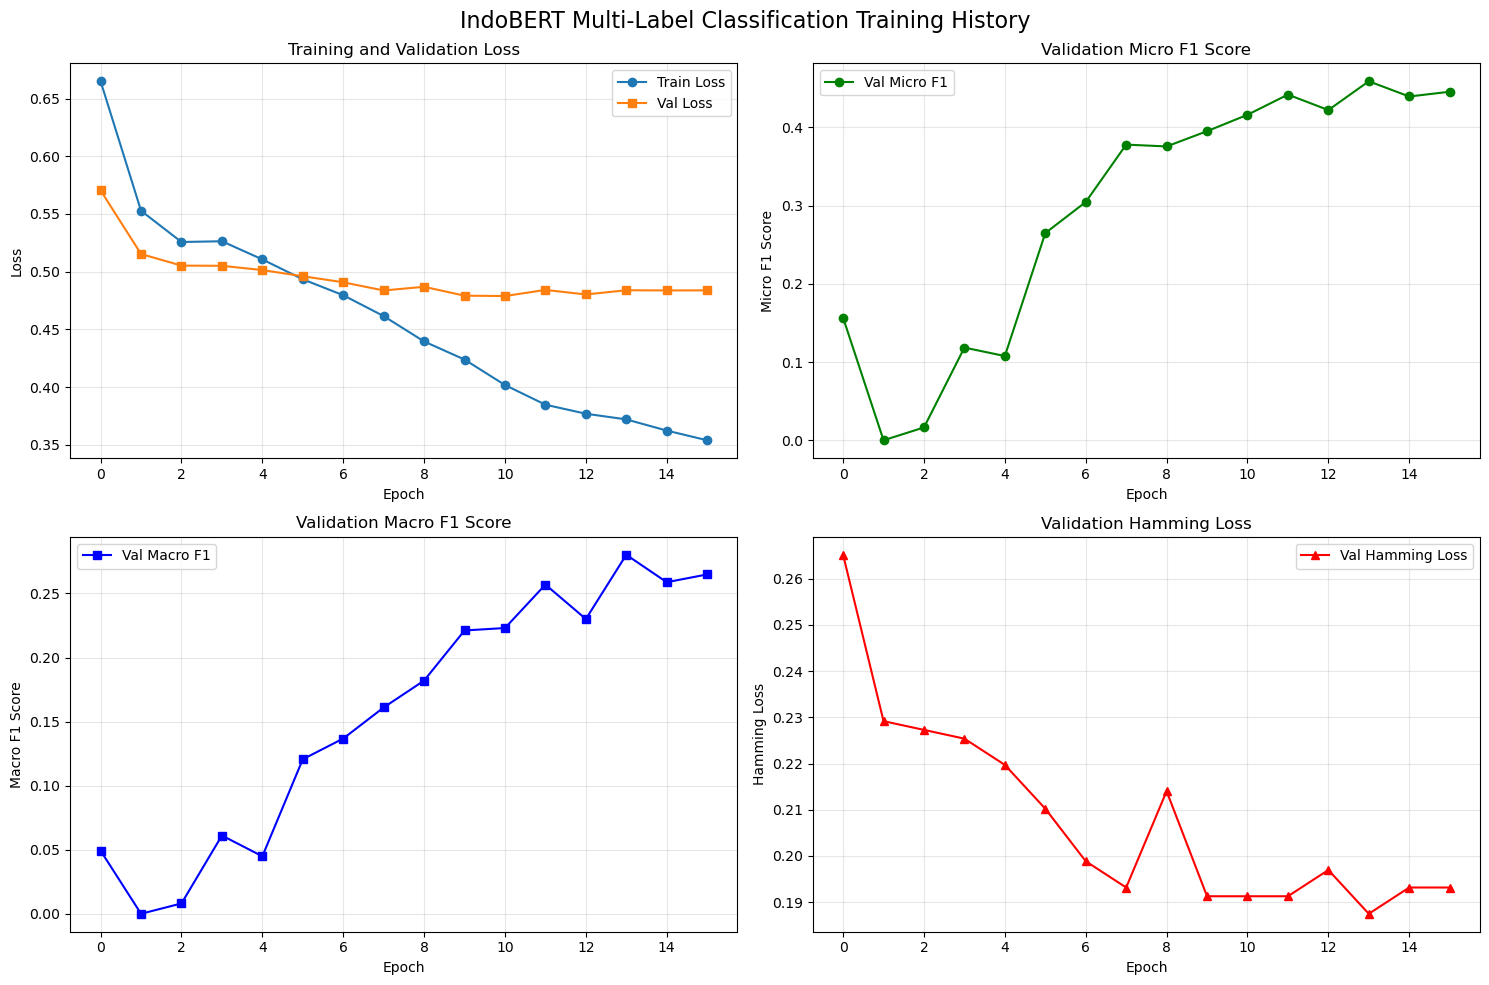


📊 Training history plots saved to 'training_history.png'


In [61]:
# === Visualization ===
import matplotlib.pyplot as plt

# Create figure with subplots
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('IndoBERT Multi-Label Classification Training History', fontsize=16)

# Plot training and validation loss
axes[0, 0].plot(training_history['train_loss'], label='Train Loss', marker='o')
axes[0, 0].plot(training_history['val_loss'], label='Val Loss', marker='s')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].set_title('Training and Validation Loss')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Plot Micro F1
axes[0, 1].plot(training_history['val_micro_f1'], label='Val Micro F1', marker='o', color='green')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Micro F1 Score')
axes[0, 1].set_title('Validation Micro F1 Score')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Plot Macro F1
axes[1, 0].plot(training_history['val_macro_f1'], label='Val Macro F1', marker='s', color='blue')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Macro F1 Score')
axes[1, 0].set_title('Validation Macro F1 Score')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Plot Hamming Loss
axes[1, 1].plot(training_history['val_hamming_loss'], label='Val Hamming Loss', marker='^', color='red')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Hamming Loss')
axes[1, 1].set_title('Validation Hamming Loss')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('training_history.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n📊 Training history plots saved to 'training_history.png'")

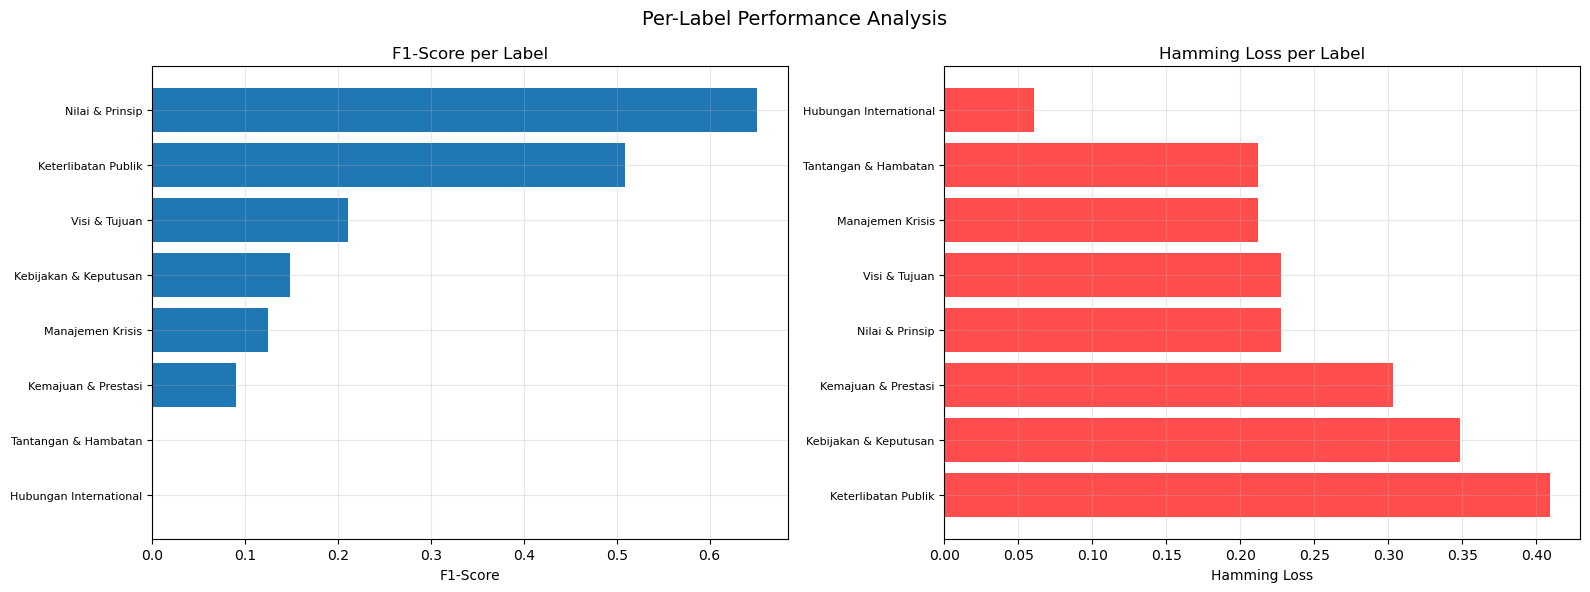


📊 Per-label performance plots saved to 'per_label_performance.png'


In [62]:
# === Per-Label Performance Visualization ===
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# F1 Score per label
label_performance_sorted = label_performance.sort_values('F1-Score')
axes[0].barh(range(len(label_performance_sorted)), label_performance_sorted['F1-Score'])
axes[0].set_yticks(range(len(label_performance_sorted)))
axes[0].set_yticklabels(label_performance_sorted['Label'], fontsize=8)
axes[0].set_xlabel('F1-Score')
axes[0].set_title('F1-Score per Label')
axes[0].grid(True, alpha=0.3)

# Hamming Loss per label
label_performance_hl = label_performance.sort_values('Hamming Loss', ascending=False)
axes[1].barh(range(len(label_performance_hl)), label_performance_hl['Hamming Loss'], color='red', alpha=0.7)
axes[1].set_yticks(range(len(label_performance_hl)))
axes[1].set_yticklabels(label_performance_hl['Label'], fontsize=8)
axes[1].set_xlabel('Hamming Loss')
axes[1].set_title('Hamming Loss per Label')
axes[1].grid(True, alpha=0.3)

plt.suptitle('Per-Label Performance Analysis', fontsize=14)
plt.tight_layout()
plt.savefig('per_label_performance.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n📊 Per-label performance plots saved to 'per_label_performance.png'")

## 3. Summary dan Kesimpulan

### Hasil Evaluasi:
- **Micro F1-Score**: Mengukur performa keseluruhan model dengan mempertimbangkan semua label
- **Macro F1-Score**: Rata-rata F1-score dari semua label (memberikan bobot yang sama untuk setiap label)
- **Hamming Loss**: Fraksi label yang salah diprediksi (semakin rendah semakin baik)

### Analisis Per-Label:
- Setiap label dievaluasi secara individual dengan metrics precision, recall, F1-score, dan hamming loss
- Label dengan F1-score tinggi menunjukkan model dapat memprediksi label tersebut dengan baik
- Label dengan hamming loss rendah menunjukkan error rate yang rendah untuk label tersebut

### File Output:
1. **best_model.pt**: Model terbaik berdasarkan validation micro F1
2. **label_performance_metrics.xlsx**: Detailed metrics untuk setiap label
3. **training_results.json**: Overall results dan configuration
4. **training_history.png**: Visualisasi training progress
5. **per_label_performance.png**: Visualisasi performa per label

In [63]:
# === Print Final Summary ===
print("\n" + "="*70)
print("FINAL SUMMARY - MULTI-LABEL CLASSIFICATION WITH INDOBERT")
print("="*70)

print("\n📊 OVERALL PERFORMANCE METRICS:")
print(f"  • Micro F1-Score: {test_results['micro_f1']:.4f}")
print(f"  • Macro F1-Score: {test_results['macro_f1']:.4f}")
print(f"  • Hamming Loss: {test_results['hamming_loss']:.4f}")

print("\n🏆 TOP 5 BEST PERFORMING LABELS:")
top_5 = label_performance.nlargest(5, 'F1-Score')[['Label', 'F1-Score', 'Hamming Loss']]
for idx, row in top_5.iterrows():
    print(f"  {idx+1}. {row['Label']}: F1={row['F1-Score']:.3f}, HL={row['Hamming Loss']:.3f}")

print("\n⚠️ LABELS NEEDING IMPROVEMENT (Bottom 5):")
bottom_5 = label_performance.nsmallest(5, 'F1-Score')[['Label', 'F1-Score', 'Hamming Loss']]
for idx, row in bottom_5.iterrows():
    print(f"  {idx+1}. {row['Label']}: F1={row['F1-Score']:.3f}, HL={row['Hamming Loss']:.3f}")

print("\n✅ All results have been saved successfully!")
print("="*70)


FINAL SUMMARY - MULTI-LABEL CLASSIFICATION WITH INDOBERT

📊 OVERALL PERFORMANCE METRICS:
  • Micro F1-Score: 0.3400
  • Macro F1-Score: 0.2169
  • Hamming Loss: 0.2500

🏆 TOP 5 BEST PERFORMING LABELS:
  6. Nilai & Prinsip: F1=0.651, HL=0.227
  4. Keterlibatan Publik: F1=0.509, HL=0.409
  8. Visi & Tujuan: F1=0.211, HL=0.227
  2. Kebijakan & Keputusan: F1=0.148, HL=0.348
  5. Manajemen Krisis: F1=0.125, HL=0.212

⚠️ LABELS NEEDING IMPROVEMENT (Bottom 5):
  1. Hubungan International: F1=0.000, HL=0.061
  7. Tantangan & Hambatan: F1=0.000, HL=0.212
  3. Kemajuan & Prestasi: F1=0.091, HL=0.303
  5. Manajemen Krisis: F1=0.125, HL=0.212
  2. Kebijakan & Keputusan: F1=0.148, HL=0.348

✅ All results have been saved successfully!
